In [2]:
from scipy.integrate import solve_ivp
from scipy.signal import lombscargle

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# derivative functions on x and y; include effect of light
# t: time (hrs)
# l (lambda): rate of return from a disturbance (hrs^-1)
# A: amplitude of base oscillation
# tau: period of base oscillation (hrs)
# ifunc: light intensity as a function of t
def cartesian_lights(t, p, l, A, tau, ifunc):
    x, y = p
    r = np.sqrt(x**2 + y**2)
    
    # see equations 4 and 5 in the paper (section 4.1)
    dx = l * x * (A - r) - 2 * np.pi * y / tau - ifunc(t)
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    
    return [dx, dy]

# get the solution of a simulated oscillator affected by the given light intensity function
# returns t, (x, y)
def get_simulation_result(l, tau, ifunc, hours, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)

    p0 = [A, 0]
    result = solve_ivp(cartesian_lights, tspan, p0, args=(l, A, tau, ifunc), t_eval=t)

    return t, result.y

In [4]:
# 12 hrs light (1), 12 hrs dark (0)
def LD_step(t):
    t_day = t % 24

    step = 1 - np.round(t_day / 24)
    return step

In [5]:
def get_simulation_period(l, tau, max_intensity, hours=144):
    intensity = lambda x: LD_step(x) * max_intensity
    
    t, (x, y) = get_simulation_result(l, tau, intensity, hours)
    
    periods = np.arange(1, 10, .01)
    
    powers = lombscargle(t[len(x)//2:], x[len(x)//2:], freqs=1/periods)
    
    peak_freq = periods[powers.argmax()] * 6.25

    return peak_freq

28.000000, 0.150000

Text(0.5, 0.98, 'Entrainment region (circadian clock period - ZT period)')

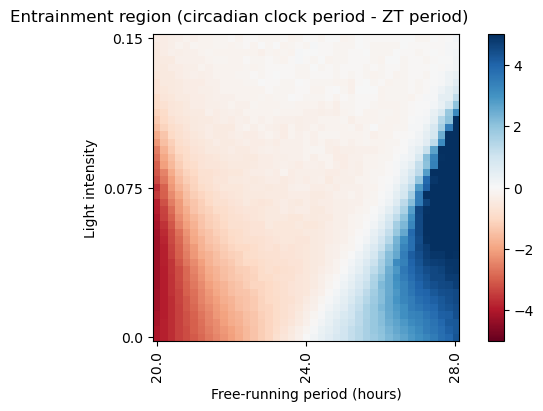

In [65]:
import sys

def ranges(i, j, tau_range, light_range, size_i, size_j):
    l = .5
    
    tau = np.interp(i, [0, size_i], tau_range)

    light = np.interp(j, [0, size_j], light_range)
    
    return np.array([tau, light])

size_x = 40
size_y = 40

im_shape = (size_x, size_y)

tau_range = [20, 28]
light_range = [0, .15]

param_array = np.fromfunction(lambda i, j: ranges(i, j, tau_range, light_range, *im_shape), (size_x + 1, size_y + 1))

def generator(x):
    l = .5
    sys.stdout.write("\r%f, %f" % (x[0], x[1]))
    sys.stdout.flush()
    return get_simulation_period(.5, x[0], x[1]) - 24

new = np.apply_along_axis(generator, 0, param_array)

fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

#ax.set_xticks(ticks=[0, size_x], labels=tau_range)
#ax.set_yticks(ticks=[0, size_y], labels=light_range)

ax.set_xticks([0, size_x / 2, size_x], labels=np.round(np.interp([0, size_x / 2, size_x], [0, size_x], tau_range), decimals=3), rotation='vertical')
ax.set_yticks([0, size_y / 2, size_y], labels=np.round(np.interp([0, size_y / 2, size_y], [0, size_y], light_range), decimals=3))

ax.set_xlabel('Free-running period (hours)')
ax.set_ylabel('Light intensity')

data = ax.imshow(new.T, cmap='RdBu', origin='lower', vmin=-5, vmax=5)

fig.colorbar(data, ax=ax)
fig.suptitle('Entrainment region (circadian clock period - ZT period)')

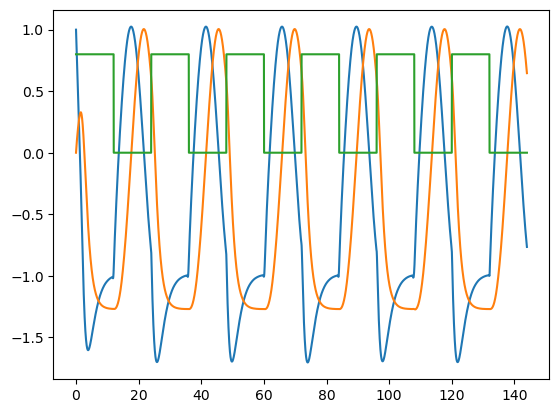

In [15]:
l = .5
tau = 16
max_intensity = .8
intensity = lambda x: LD_step(x) * max_intensity
hours = 144

t, (x, y) = get_simulation_result(l, tau, intensity, hours)

plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, intensity(t))